In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import os
#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go
#offline.init_notebook_mode()
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Flatten,Reshape
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
import csv
from tensorflow.keras.models import Model
#import keras
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Input,Concatenate,Dropout,Dense,BatchNormalization,Conv1D
from tensorflow.keras.layers import Input
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
#from tensorflow.keras.merge import concatenate
#import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import scipy
from tensorflow.keras.initializers import he_normal,glorot_normal
from tensorflow.keras.regularizers import l1,l2
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from time import time
from tensorflow.keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
train=pd.read_csv('/content/gdrive/MyDrive/PersonalizedCancerDiagnosis/train_final.csv')
test=pd.read_csv('/content/gdrive/MyDrive/PersonalizedCancerDiagnosis/test_final.csv')

In [12]:
train.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [13]:
labels=tf.keras.utils.to_categorical(train['Class'].values,num_classes=10)
labels.shape

(3321, 10)

In [14]:
y=train['Class']
X=train.drop(['Class','ID'],axis=1)

In [15]:
test=test.drop(['ID'],axis=1)

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,labels,test_size=0.3,random_state=42,stratify=labels)

In [17]:
def pad_text(text,tokenizer,max_len):
    return pad_sequences(tokenizer.texts_to_sequences(text),maxlen=max_len,padding='post')

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
def text_padding(train_final,train,test,max_len):
    vocab=5000
    token=Tokenizer()
    token.fit_on_texts(train_final)
    padded_train_text=pad_text(train,token,max_len)
    padded_test_text=pad_text(test,token,max_len)
    return padded_train_text,padded_test_text,token

In [20]:
comm_len=200
train_text_pad,test_text_pad,token_com= text_padding(train['TEXT'],X_train['TEXT'],X_test['TEXT'],comm_len)

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p /drive2
!google-drive-ocamlfuse /drive2

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [21]:
def generate_embedding_matrix(token):
    embedding_path='/content/gdrive/MyDrive/crawl-300d-2M.vec'
    embedding_dimension=300
    embedding_index={}
    with open(embedding_path) as f:
         for line in f:
             values=line.split()
             word=values[0]
             coefs=np.asarray(values[1:],dtype='float32')
             embedding_index[word]=coefs
    f.close()        
    embedding_matrix=np.zeros((len(token.word_index)+1,embedding_dimension))
    num_words_in_embedding = 0
    for word, i in token.word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
           embedding_matrix[i] = embedding_vector
        #print("embedding matrix shape",embedding_matrix.shape)
    return embedding_matrix

In [22]:
%%time
embedding_comm = generate_embedding_matrix(token_com)
print(embedding_comm.shape)

(153073, 300)
CPU times: user 2min 37s, sys: 13 s, total: 2min 50s
Wall time: 3min


In [23]:
def LabelEncoder_val(train_final,train,test):
  label=LabelEncoder()
  label.fit(train_final)
  train_ohe=label.transform(train)
  test_ohe=label.transform(test)
  return train_ohe,test_ohe

In [24]:
train_gene,test_gene=LabelEncoder_val(train['Gene'].values,X_train['Gene'],X_test['Gene'])

In [25]:
no_of_unique_gene=train['Gene'].nunique()
embedding_size_gene = max(no_of_unique_gene, 500 )
vocab_gene  = no_of_unique_gene + 1

In [26]:
train_variation,test_variation=LabelEncoder_val(train['Variation'].values,X_train['Variation'].values,X_test['Variation'].values)

In [27]:
no_of_unique_variation=train['Variation'].nunique()
embedding_size_variation = max(no_of_unique_variation, 500 )
vocab_variation = no_of_unique_variation + 1

In [28]:
from tensorflow.keras.layers import concatenate
def LSTM_Model1(comm_len,token_com,vocab_gene ,embedding_size_gene,vocab_variation ,embedding_size_variation):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
  
    input_text_1=Input(shape=(comm_len,), name='TEXT', dtype='float32')
    sequence_input_1=Embedding(len(token_com.word_index) + 1,300,weights=[embedding_comm],input_length=comm_len,trainable=False,dtype=tf.float32)(input_text_1)
    sequence_input_1=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)
    
    input_text_2=Input(shape=(1,),name='GENE', dtype='float32')
    sequence_input_2=Embedding(vocab_gene ,embedding_size_gene,input_length=1)(input_text_2)
    sequence_input_2=Flatten()(sequence_input_2)

    input_text_3=Input(shape=(1,),name='Variation', dtype='float32')
    sequence_input_3=Embedding(vocab_variation ,embedding_size_variation,input_length=1)(input_text_3)
    sequence_input_3=Flatten()(sequence_input_3)
    
  
    concat=concatenate([sequence_input_1,sequence_input_2,sequence_input_3],dtype=tf.float32)
  
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
  
    final_output=Dense(10,activation='softmax')(y)
  
    model= Model(inputs=[input_text_1,input_text_2,input_text_3],outputs=final_output)
    return model

In [29]:
model=LSTM_Model1(comm_len,token_com,vocab_gene ,embedding_size_gene,vocab_variation ,embedding_size_variation)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TEXT (InputLayer)               [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     45921900    TEXT[0][0]                       
__________________________________________________________________________________________________
GENE (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Variation (InputLayer)          [(None, 1)]          0                                            
______________________________________________________________________________________________

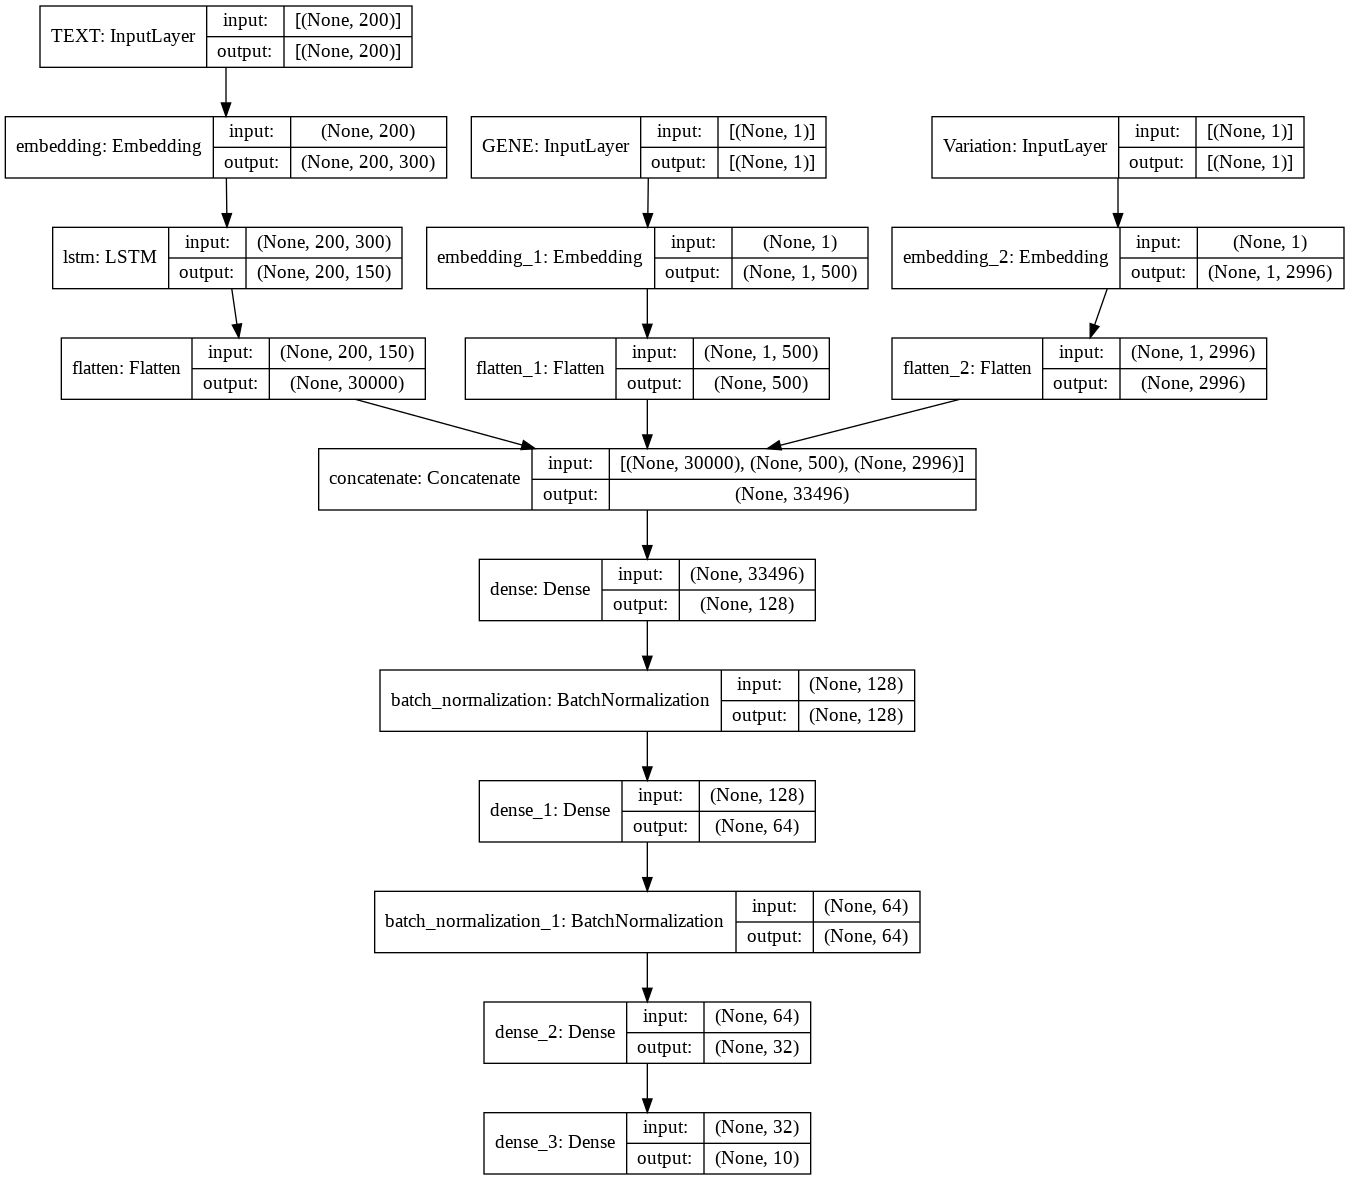

In [30]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [31]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy',metrics='accuracy')

In [32]:
from tensorflow.keras.callbacks import *
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min')
earlystop = EarlyStopping(monitor = 'val_loss',  mode="min",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, verbose = 1)
%load_ext tensorboard
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, batch_size=256, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard]

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
train_s=[train_text_pad,train_gene,train_variation]
test_s=[test_text_pad,test_gene,test_variation]

In [36]:
score_1=model.fit(x=train_s,y=y_train,validation_data=(test_s, y_test),epochs=50,callbacks=callbacks)

Epoch 1/50
73/73 [==============================] - 14s 80ms/step - loss: 6.4857 - accuracy: 0.3395 - val_loss: 6.3166 - val_accuracy: 0.4835

Epoch 00001: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 2/50
73/73 [==============================] - 5s 66ms/step - loss: 5.5679 - accuracy: 0.6076 - val_loss: 5.9746 - val_accuracy: 0.5005

Epoch 00002: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 3/50
73/73 [==============================] - 4s 61ms/step - loss: 5.1350 - accuracy: 0.6923 - val_loss: 5.6227 - val_accuracy: 0.5807

Epoch 00003: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 4/50
73/73 [==============================] - 5s 64ms/step - loss: 4.7995 - accuracy: 0.7470 - val_loss: 5.3497 - val_accuracy: 0.5587

Epoch 00004: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 5/50
73/73 [==============================] - 5s 62ms/step - loss: 4.5219 - accuracy: 0.7909 - val_loss: 5.0264 - val_accuracy: 0.6068

Epoch 00005: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 6/50
73/73 [==============================] - 4s 61ms/step - loss: 4.2789 - accuracy: 0.8133 - val_loss: 4.8690 - val_accuracy: 0.5968

Epoch 00006: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 7/50
73/73 [==============================] - 4s 61ms/step - loss: 4.0584 - accuracy: 0.8292 - val_loss: 4.6665 - val_accuracy: 0.6259

Epoch 00007: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 8/50
73/73 [==============================] - 5s 63ms/step - loss: 3.8474 - accuracy: 0.8503 - val_loss: 4.4895 - val_accuracy: 0.6028

Epoch 00008: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 9/50
73/73 [==============================] - 5s 65ms/step - loss: 3.6556 - accuracy: 0.8597 - val_loss: 4.3715 - val_accuracy: 0.6309

Epoch 00009: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 10/50
73/73 [==============================] - 5s 63ms/step - loss: 3.4587 - accuracy: 0.8808 - val_loss: 4.2547 - val_accuracy: 0.6229

Epoch 00010: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 11/50
73/73 [==============================] - 4s 61ms/step - loss: 3.2835 - accuracy: 0.8980 - val_loss: 4.1272 - val_accuracy: 0.6048

Epoch 00011: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 12/50
73/73 [==============================] - 4s 61ms/step - loss: 3.1078 - accuracy: 0.9109 - val_loss: 4.0335 - val_accuracy: 0.5848

Epoch 00012: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 13/50
73/73 [==============================] - 5s 62ms/step - loss: 2.9148 - accuracy: 0.9329 - val_loss: 3.8264 - val_accuracy: 0.6038

Epoch 00013: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 14/50
73/73 [==============================] - 5s 63ms/step - loss: 2.7495 - accuracy: 0.9531 - val_loss: 3.7677 - val_accuracy: 0.6028

Epoch 00014: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 15/50
73/73 [==============================] - 5s 64ms/step - loss: 2.5994 - accuracy: 0.9630 - val_loss: 3.6293 - val_accuracy: 0.5868

Epoch 00015: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 16/50
73/73 [==============================] - 5s 66ms/step - loss: 2.4549 - accuracy: 0.9768 - val_loss: 3.5165 - val_accuracy: 0.5958

Epoch 00016: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 17/50
73/73 [==============================] - 5s 63ms/step - loss: 2.3170 - accuracy: 0.9806 - val_loss: 3.3788 - val_accuracy: 0.5988

Epoch 00017: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 18/50
73/73 [==============================] - 4s 61ms/step - loss: 2.1917 - accuracy: 0.9875 - val_loss: 3.3144 - val_accuracy: 0.5978

Epoch 00018: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 19/50
73/73 [==============================] - 4s 61ms/step - loss: 2.0730 - accuracy: 0.9905 - val_loss: 3.2467 - val_accuracy: 0.6008

Epoch 00019: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 20/50
73/73 [==============================] - 5s 65ms/step - loss: 1.9687 - accuracy: 0.9892 - val_loss: 3.1695 - val_accuracy: 0.6008

Epoch 00020: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 21/50
73/73 [==============================] - 5s 64ms/step - loss: 1.8663 - accuracy: 0.9918 - val_loss: 3.0523 - val_accuracy: 0.6269

Epoch 00021: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 22/50
73/73 [==============================] - 5s 62ms/step - loss: 1.7592 - accuracy: 0.9944 - val_loss: 2.9646 - val_accuracy: 0.5978

Epoch 00022: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 23/50
73/73 [==============================] - 5s 62ms/step - loss: 1.6765 - accuracy: 0.9948 - val_loss: 2.9254 - val_accuracy: 0.5827

Epoch 00023: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 24/50
73/73 [==============================] - 5s 66ms/step - loss: 1.6016 - accuracy: 0.9910 - val_loss: 2.8442 - val_accuracy: 0.5908

Epoch 00024: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 25/50
73/73 [==============================] - 5s 65ms/step - loss: 1.5155 - accuracy: 0.9931 - val_loss: 2.8301 - val_accuracy: 0.5777

Epoch 00025: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 26/50
73/73 [==============================] - 5s 64ms/step - loss: 1.4442 - accuracy: 0.9927 - val_loss: 2.7305 - val_accuracy: 0.6078

Epoch 00026: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 27/50
73/73 [==============================] - 5s 62ms/step - loss: 1.3733 - accuracy: 0.9918 - val_loss: 2.6854 - val_accuracy: 0.6008

Epoch 00027: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 28/50
73/73 [==============================] - 5s 64ms/step - loss: 1.2949 - accuracy: 0.9940 - val_loss: 2.7483 - val_accuracy: 0.6008

Epoch 00028: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 29/50
73/73 [==============================] - 5s 64ms/step - loss: 1.2403 - accuracy: 0.9931 - val_loss: 2.5405 - val_accuracy: 0.5717

Epoch 00029: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 30/50
73/73 [==============================] - 5s 63ms/step - loss: 1.1833 - accuracy: 0.9935 - val_loss: 2.5710 - val_accuracy: 0.5727

Epoch 00030: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 31/50
73/73 [==============================] - 5s 66ms/step - loss: 1.1138 - accuracy: 0.9970 - val_loss: 2.5359 - val_accuracy: 0.5627

Epoch 00031: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 32/50
73/73 [==============================] - 5s 64ms/step - loss: 1.0604 - accuracy: 0.9944 - val_loss: 2.4036 - val_accuracy: 0.5767

Epoch 00032: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 33/50
73/73 [==============================] - 5s 62ms/step - loss: 1.0171 - accuracy: 0.9935 - val_loss: 2.4041 - val_accuracy: 0.5888

Epoch 00033: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 34/50
73/73 [==============================] - 5s 63ms/step - loss: 0.9664 - accuracy: 0.9953 - val_loss: 2.5350 - val_accuracy: 0.5336

Epoch 00034: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 35/50
73/73 [==============================] - 5s 64ms/step - loss: 0.9250 - accuracy: 0.9974 - val_loss: 2.2176 - val_accuracy: 0.6078

Epoch 00035: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 36/50
73/73 [==============================] - 5s 65ms/step - loss: 0.9057 - accuracy: 0.9991 - val_loss: 2.2067 - val_accuracy: 0.6329

Epoch 00036: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 37/50
73/73 [==============================] - 5s 62ms/step - loss: 0.8930 - accuracy: 0.9991 - val_loss: 2.2169 - val_accuracy: 0.6179

Epoch 00037: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 38/50
73/73 [==============================] - 5s 65ms/step - loss: 0.8794 - accuracy: 0.9991 - val_loss: 2.1901 - val_accuracy: 0.6379

Epoch 00038: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 39/50
73/73 [==============================] - 5s 66ms/step - loss: 0.8656 - accuracy: 0.9991 - val_loss: 2.1908 - val_accuracy: 0.6329

Epoch 00039: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 40/50
73/73 [==============================] - 5s 65ms/step - loss: 0.8528 - accuracy: 1.0000 - val_loss: 2.1725 - val_accuracy: 0.6209

Epoch 00040: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 41/50
73/73 [==============================] - 5s 65ms/step - loss: 0.8401 - accuracy: 1.0000 - val_loss: 2.1625 - val_accuracy: 0.6229

Epoch 00041: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 42/50
73/73 [==============================] - 5s 65ms/step - loss: 0.8288 - accuracy: 1.0000 - val_loss: 2.1505 - val_accuracy: 0.6279

Epoch 00042: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 43/50
73/73 [==============================] - 5s 66ms/step - loss: 0.8175 - accuracy: 0.9991 - val_loss: 2.1334 - val_accuracy: 0.6319

Epoch 00043: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 44/50
73/73 [==============================] - 5s 63ms/step - loss: 0.8029 - accuracy: 1.0000 - val_loss: 2.1254 - val_accuracy: 0.6309

Epoch 00044: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 45/50
73/73 [==============================] - 5s 63ms/step - loss: 0.7903 - accuracy: 0.9996 - val_loss: 2.1118 - val_accuracy: 0.6319

Epoch 00045: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 46/50
73/73 [==============================] - 5s 63ms/step - loss: 0.7776 - accuracy: 0.9996 - val_loss: 2.1552 - val_accuracy: 0.6319

Epoch 00046: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 47/50
73/73 [==============================] - 5s 64ms/step - loss: 0.7656 - accuracy: 0.9996 - val_loss: 2.1072 - val_accuracy: 0.6309

Epoch 00047: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 48/50
73/73 [==============================] - 5s 63ms/step - loss: 0.7514 - accuracy: 1.0000 - val_loss: 2.0864 - val_accuracy: 0.6299

Epoch 00048: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 49/50
73/73 [==============================] - 5s 62ms/step - loss: 0.7388 - accuracy: 0.9996 - val_loss: 2.0784 - val_accuracy: 0.6359

Epoch 00049: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 50/50
73/73 [==============================] - 5s 66ms/step - loss: 0.7271 - accuracy: 1.0000 - val_loss: 2.0846 - val_accuracy: 0.6349

Epoch 00050: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


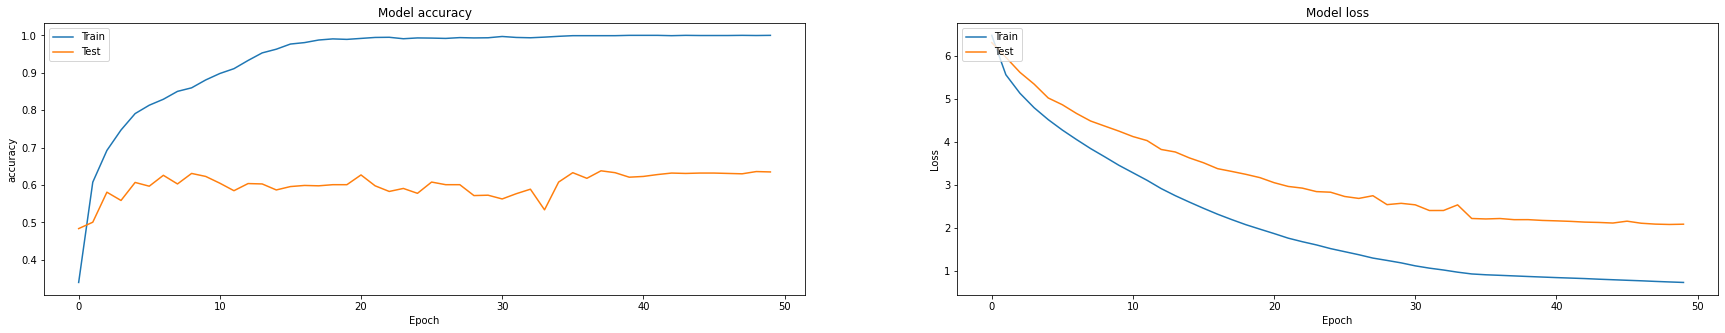

In [38]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(score_1.history['accuracy'])
plt.plot(score_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(score_1.history['loss'])
plt.plot(score_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model:-2

In [41]:
def LSTM_Model2(comm_len,token_com,vocab_gene ,embedding_size_gene,vocab_variation ,embedding_size_variation):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
  
    input_text_1=Input(shape=(comm_len,), name='TEXT', dtype='float32')
    sequence_input_1=Embedding(len(token_com.word_index) + 1,300,weights=[embedding_comm],input_length=comm_len,trainable=False,dtype=tf.float32)(input_text_1)
    sequence_input_1=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)
    
    input_text_2=Input(shape=(1,),name='GENE', dtype='float32')
    sequence_input_2=Embedding(vocab_gene ,embedding_size_gene,input_length=1)(input_text_2)
    sequence_input_2=Flatten()(sequence_input_2)

    input_text_3=Input(shape=(1,),name='Variation', dtype='float32')
    sequence_input_3=Embedding(vocab_variation ,embedding_size_variation,input_length=1)(input_text_3)
    sequence_input_3=Flatten()(sequence_input_3)
    
  
    concat=concatenate([sequence_input_1,sequence_input_2,sequence_input_3],dtype=tf.float32)
  
    y = Dense(1024,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y = Dense(512,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y = Dense(256,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
  
    final_output=Dense(10,activation='softmax')(y)
  
    model= Model(inputs=[input_text_1,input_text_2,input_text_3],outputs=final_output)
    return model

In [42]:
model=LSTM_Model2(comm_len,token_com,vocab_gene ,embedding_size_gene,vocab_variation ,embedding_size_variation)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TEXT (InputLayer)               [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 200, 300)     45921900    TEXT[0][0]                       
__________________________________________________________________________________________________
GENE (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Variation (InputLayer)          [(None, 1)]          0                                            
____________________________________________________________________________________________

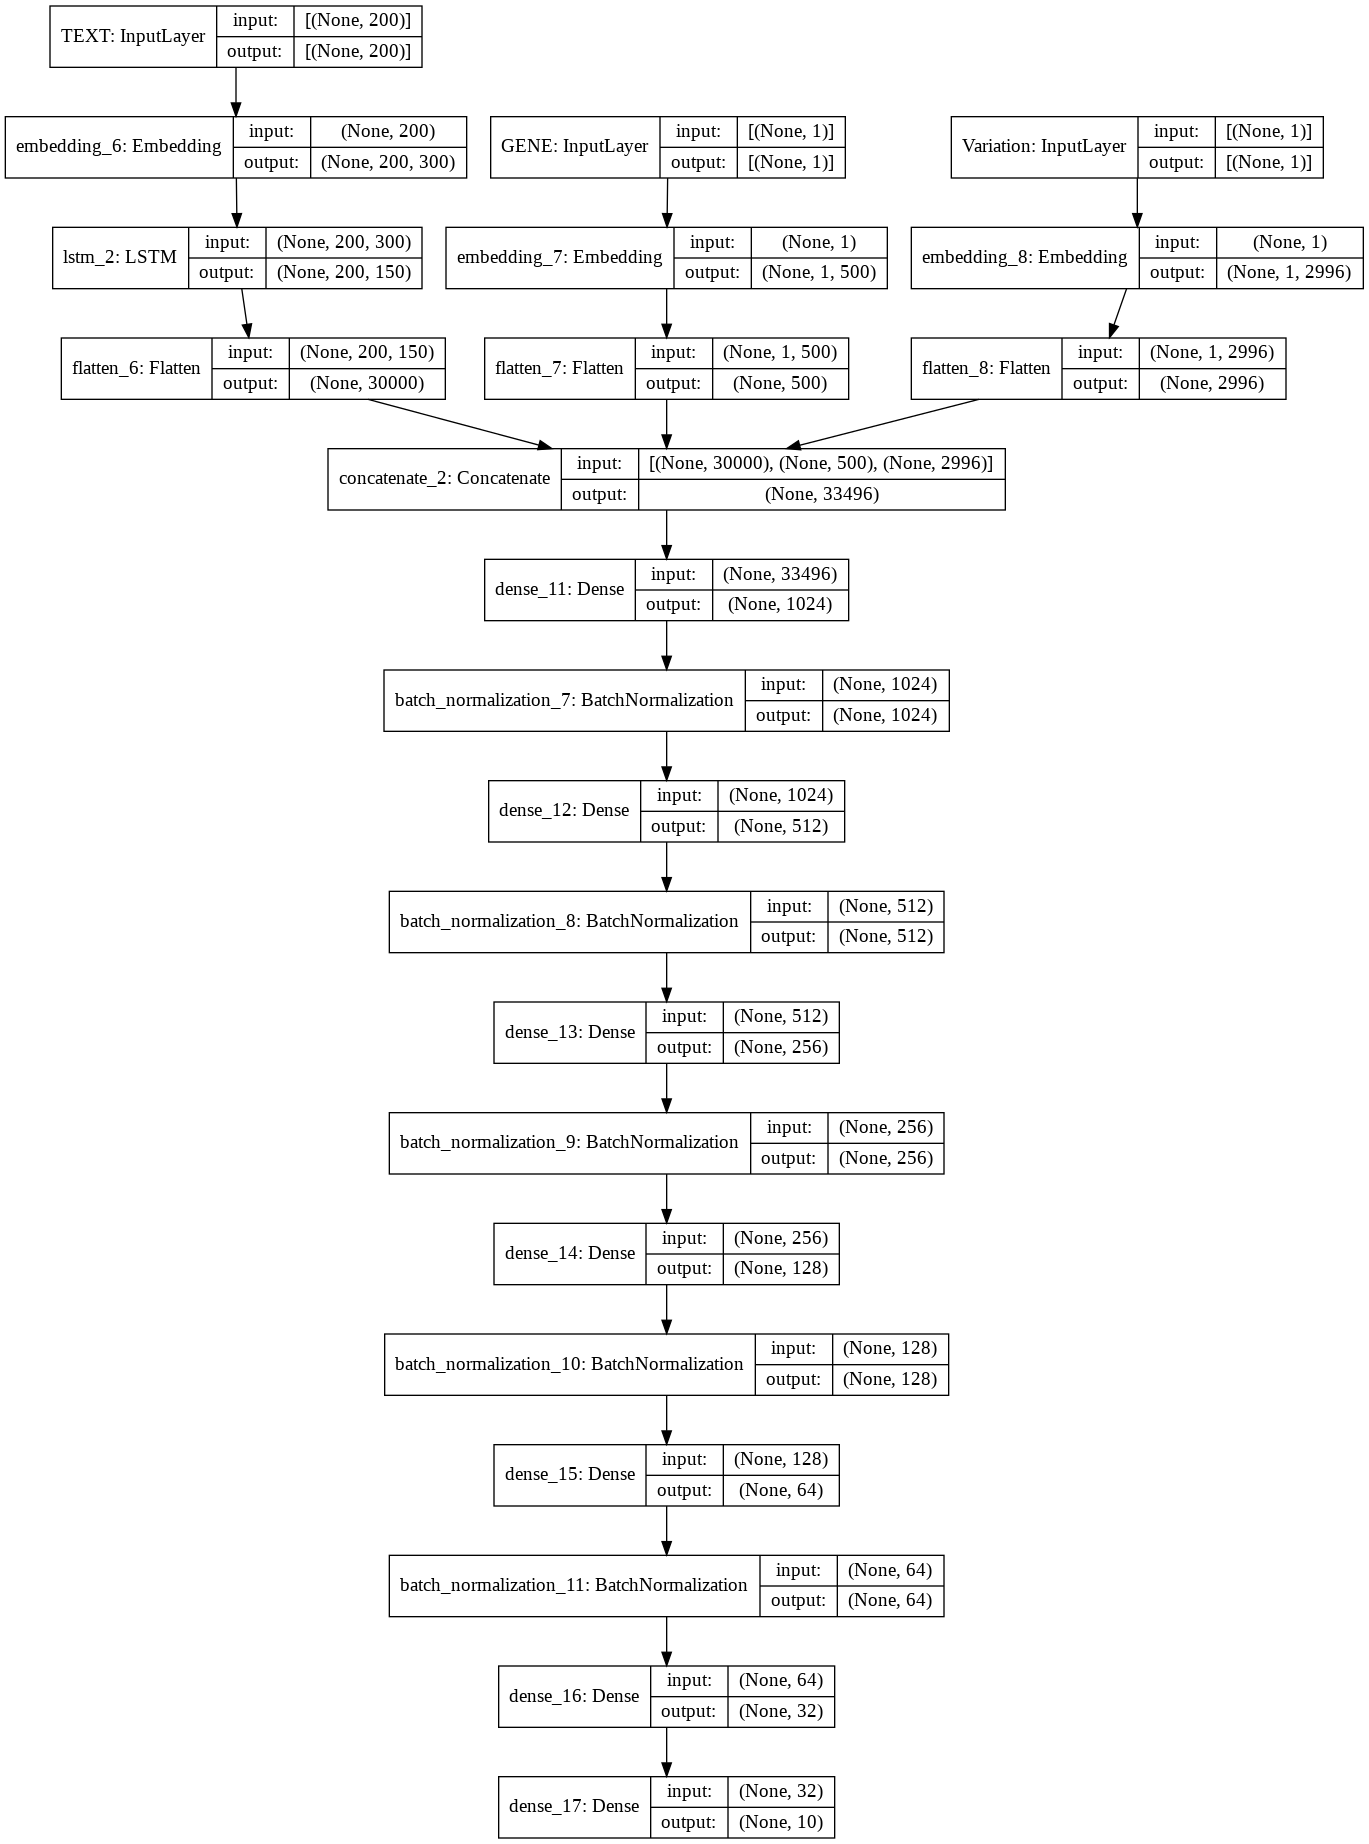

In [43]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [44]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy',metrics='accuracy')

In [46]:
from tensorflow.keras.callbacks import *
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min')
earlystop = EarlyStopping(monitor = 'val_loss',  mode="min",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, verbose = 1)
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, batch_size=256, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard]

In [47]:
score_2=model.fit(x=train_s,y=y_train,validation_data=(test_s, y_test),epochs=50,callbacks=callbacks)

Epoch 1/50
73/73 [==============================] - 12s 116ms/step - loss: 41.9190 - accuracy: 0.2470 - val_loss: 40.9267 - val_accuracy: 0.3340

Epoch 00001: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 2/50
73/73 [==============================] - 7s 99ms/step - loss: 39.4690 - accuracy: 0.5202 - val_loss: 38.8083 - val_accuracy: 0.4363

Epoch 00002: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 3/50
73/73 [==============================] - 6s 89ms/step - loss: 37.0854 - accuracy: 0.6682 - val_loss: 36.5372 - val_accuracy: 0.5296

Epoch 00003: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 4/50
73/73 [==============================] - 7s 90ms/step - loss: 34.8048 - accuracy: 0.7332 - val_loss: 34.2768 - val_accuracy: 0.5587

Epoch 00004: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 5/50
73/73 [==============================] - 7s 98ms/step - loss: 32.6040 - accuracy: 0.7577 - val_loss: 32.1230 - val_accuracy: 0.5838

Epoch 00005: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 6/50
73/73 [==============================] - 7s 98ms/step - loss: 30.5137 - accuracy: 0.7844 - val_loss: 30.1323 - val_accuracy: 0.5848

Epoch 00006: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 7/50
73/73 [==============================] - 7s 99ms/step - loss: 28.5164 - accuracy: 0.7801 - val_loss: 28.2037 - val_accuracy: 0.5878

Epoch 00007: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 8/50
73/73 [==============================] - 7s 97ms/step - loss: 26.6290 - accuracy: 0.7960 - val_loss: 26.3875 - val_accuracy: 0.5948

Epoch 00008: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 9/50
73/73 [==============================] - 6s 89ms/step - loss: 24.8512 - accuracy: 0.7969 - val_loss: 24.7081 - val_accuracy: 0.6078

Epoch 00009: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 10/50
73/73 [==============================] - 7s 90ms/step - loss: 23.1760 - accuracy: 0.8038 - val_loss: 23.1432 - val_accuracy: 0.5938

Epoch 00010: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 11/50
73/73 [==============================] - 6s 89ms/step - loss: 21.6262 - accuracy: 0.8120 - val_loss: 21.7176 - val_accuracy: 0.5667

Epoch 00011: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 12/50
73/73 [==============================] - 7s 90ms/step - loss: 20.1739 - accuracy: 0.8077 - val_loss: 20.2606 - val_accuracy: 0.6128

Epoch 00012: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 13/50
73/73 [==============================] - 7s 98ms/step - loss: 18.8092 - accuracy: 0.8154 - val_loss: 18.9868 - val_accuracy: 0.5938

Epoch 00013: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 14/50
73/73 [==============================] - 6s 89ms/step - loss: 17.5428 - accuracy: 0.8145 - val_loss: 17.7077 - val_accuracy: 0.6068

Epoch 00014: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 15/50
73/73 [==============================] - 7s 99ms/step - loss: 16.3686 - accuracy: 0.8219 - val_loss: 16.6145 - val_accuracy: 0.5988

Epoch 00015: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 16/50
73/73 [==============================] - 6s 89ms/step - loss: 15.2885 - accuracy: 0.8193 - val_loss: 15.6465 - val_accuracy: 0.5737

Epoch 00016: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 17/50
73/73 [==============================] - 7s 98ms/step - loss: 14.2853 - accuracy: 0.8253 - val_loss: 14.6771 - val_accuracy: 0.5988

Epoch 00017: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 18/50
73/73 [==============================] - 7s 91ms/step - loss: 13.3609 - accuracy: 0.8188 - val_loss: 13.7548 - val_accuracy: 0.6229

Epoch 00018: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 19/50
73/73 [==============================] - 6s 89ms/step - loss: 12.4681 - accuracy: 0.8395 - val_loss: 12.9579 - val_accuracy: 0.5898

Epoch 00019: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 20/50
73/73 [==============================] - 6s 89ms/step - loss: 11.6744 - accuracy: 0.8425 - val_loss: 12.2116 - val_accuracy: 0.6018

Epoch 00020: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 21/50
73/73 [==============================] - 7s 90ms/step - loss: 10.9384 - accuracy: 0.8408 - val_loss: 11.5714 - val_accuracy: 0.5878

Epoch 00021: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 22/50
73/73 [==============================] - 6s 88ms/step - loss: 10.2554 - accuracy: 0.8511 - val_loss: 10.9213 - val_accuracy: 0.6098

Epoch 00022: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 23/50
73/73 [==============================] - 7s 99ms/step - loss: 9.6108 - accuracy: 0.8619 - val_loss: 10.2757 - val_accuracy: 0.6209

Epoch 00023: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 24/50
73/73 [==============================] - 6s 89ms/step - loss: 9.0068 - accuracy: 0.8843 - val_loss: 9.7607 - val_accuracy: 0.6058

Epoch 00024: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 25/50
73/73 [==============================] - 7s 98ms/step - loss: 8.4708 - accuracy: 0.8907 - val_loss: 9.2484 - val_accuracy: 0.6108

Epoch 00025: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 26/50
73/73 [==============================] - 7s 90ms/step - loss: 7.9439 - accuracy: 0.9088 - val_loss: 8.8708 - val_accuracy: 0.6098

Epoch 00026: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 27/50
73/73 [==============================] - 6s 88ms/step - loss: 7.4557 - accuracy: 0.9131 - val_loss: 8.4029 - val_accuracy: 0.5948

Epoch 00027: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 28/50
73/73 [==============================] - 6s 89ms/step - loss: 7.0603 - accuracy: 0.9114 - val_loss: 8.3479 - val_accuracy: 0.5346

Epoch 00028: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 29/50
73/73 [==============================] - 7s 99ms/step - loss: 6.6272 - accuracy: 0.9256 - val_loss: 7.6258 - val_accuracy: 0.6148

Epoch 00029: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 30/50
73/73 [==============================] - 6s 89ms/step - loss: 6.2698 - accuracy: 0.9316 - val_loss: 7.3658 - val_accuracy: 0.5938

Epoch 00030: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 31/50
73/73 [==============================] - 7s 90ms/step - loss: 5.8941 - accuracy: 0.9466 - val_loss: 7.0490 - val_accuracy: 0.5807

Epoch 00031: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 32/50
73/73 [==============================] - 6s 88ms/step - loss: 5.5477 - accuracy: 0.9522 - val_loss: 6.7447 - val_accuracy: 0.5577

Epoch 00032: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 33/50
73/73 [==============================] - 7s 97ms/step - loss: 5.2186 - accuracy: 0.9591 - val_loss: 6.4584 - val_accuracy: 0.5928

Epoch 00033: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 34/50
73/73 [==============================] - 7s 90ms/step - loss: 4.9362 - accuracy: 0.9570 - val_loss: 6.1740 - val_accuracy: 0.5848

Epoch 00034: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 35/50
73/73 [==============================] - 6s 89ms/step - loss: 4.6872 - accuracy: 0.9548 - val_loss: 6.1213 - val_accuracy: 0.5416

Epoch 00035: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 36/50
73/73 [==============================] - 7s 98ms/step - loss: 4.4638 - accuracy: 0.9565 - val_loss: 5.6751 - val_accuracy: 0.5928

Epoch 00036: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 37/50
73/73 [==============================] - 6s 88ms/step - loss: 4.2695 - accuracy: 0.9509 - val_loss: 5.8698 - val_accuracy: 0.5647

Epoch 00037: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 38/50
73/73 [==============================] - 6s 89ms/step - loss: 4.0947 - accuracy: 0.9522 - val_loss: 5.6057 - val_accuracy: 0.5587

Epoch 00038: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 39/50
73/73 [==============================] - 7s 91ms/step - loss: 3.9097 - accuracy: 0.9535 - val_loss: 5.3696 - val_accuracy: 0.5236

Epoch 00039: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 40/50
73/73 [==============================] - 7s 98ms/step - loss: 3.7017 - accuracy: 0.9673 - val_loss: 5.0259 - val_accuracy: 0.5456

Epoch 00040: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 41/50
73/73 [==============================] - 7s 90ms/step - loss: 3.5393 - accuracy: 0.9634 - val_loss: 4.7254 - val_accuracy: 0.6028

Epoch 00041: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 42/50
73/73 [==============================] - 6s 89ms/step - loss: 3.3965 - accuracy: 0.9621 - val_loss: 4.6759 - val_accuracy: 0.5396

Epoch 00042: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 43/50
73/73 [==============================] - 6s 88ms/step - loss: 3.2535 - accuracy: 0.9583 - val_loss: 4.6712 - val_accuracy: 0.5045

Epoch 00043: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 44/50
73/73 [==============================] - 7s 91ms/step - loss: 3.0737 - accuracy: 0.9694 - val_loss: 4.6068 - val_accuracy: 0.5476

Epoch 00044: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 45/50
73/73 [==============================] - 6s 89ms/step - loss: 2.9048 - accuracy: 0.9742 - val_loss: 4.3127 - val_accuracy: 0.5657

Epoch 00045: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 46/50
73/73 [==============================] - 7s 90ms/step - loss: 2.7953 - accuracy: 0.9647 - val_loss: 4.1842 - val_accuracy: 0.5125

Epoch 00046: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 47/50
73/73 [==============================] - 7s 98ms/step - loss: 2.6910 - accuracy: 0.9703 - val_loss: 4.2322 - val_accuracy: 0.5105

Epoch 00047: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 48/50
73/73 [==============================] - 6s 89ms/step - loss: 2.5791 - accuracy: 0.9690 - val_loss: 4.0318 - val_accuracy: 0.5547

Epoch 00048: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 49/50
73/73 [==============================] - 7s 90ms/step - loss: 2.4195 - accuracy: 0.9815 - val_loss: 3.7457 - val_accuracy: 0.6199

Epoch 00049: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 50/50
73/73 [==============================] - 6s 89ms/step - loss: 2.3121 - accuracy: 0.9785 - val_loss: 3.7004 - val_accuracy: 0.5988

Epoch 00050: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


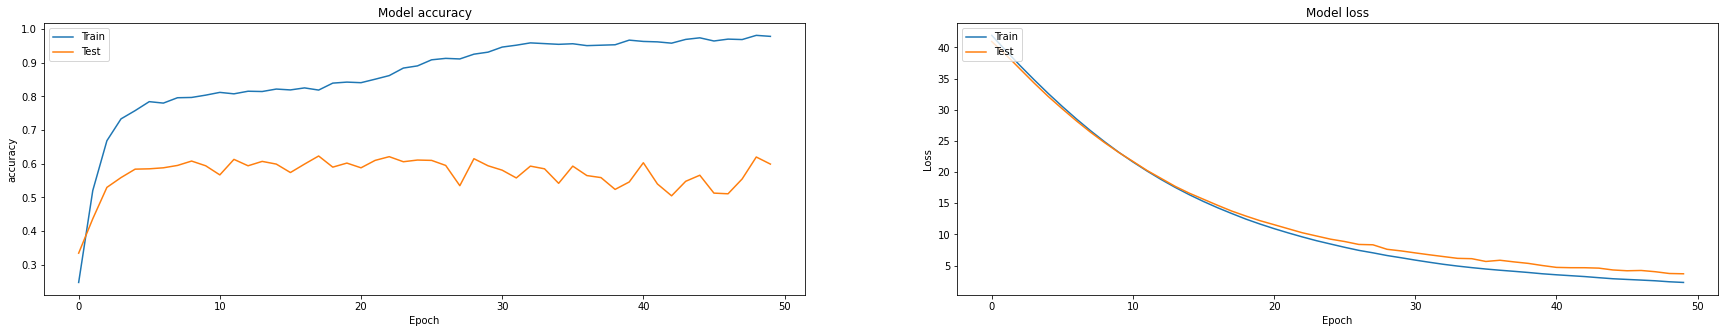

In [48]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(score_2.history['accuracy'])
plt.plot(score_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(score_2.history['loss'])
plt.plot(score_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [55]:
import matplotlib.pyplot as plt
labels=['0', '1','2','3','4','5','6','7','8','9']
def plot_confusion_matrix(cm,classes=labels,normalize=True,title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(16,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [56]:
from sklearn.metrics import accuracy_score
y_pred=model.predict(test_s)
y_test_=np.argmax(y_test, axis=-1)
y_pred_=np.argmax(y_pred, axis=-1)
print('Valid Accuracy:-',accuracy_score(y_test_,y_pred_))

Valid Accuracy:- 0.5987963891675026


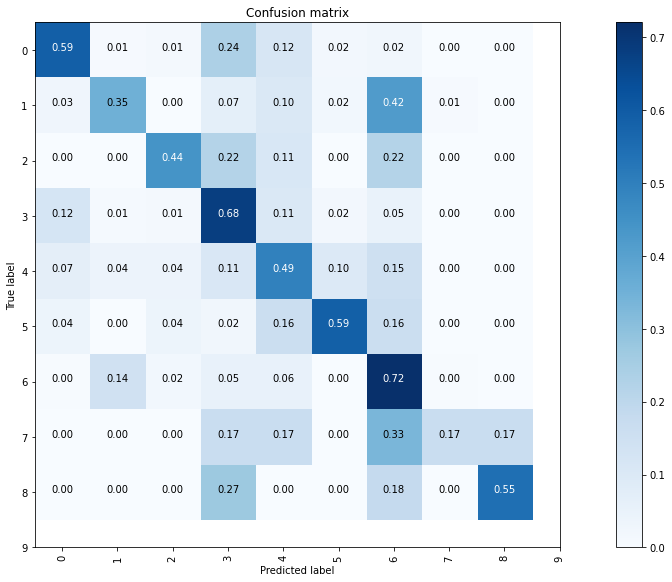

In [57]:
from sklearn.metrics import confusion_matrix
import itertools
cm = confusion_matrix(y_test_, y_pred_)
plot_confusion_matrix(cm,labels)

# CNN1D Model

In [59]:
def Count_vectorizer(train_final,train,test):
  vec=CountVectorizer()
  vec.fit(train_final)
  train_new=vec.transform(train)
  test_new=vec.transform(test)
  return train_new,test_new

In [61]:
train_gene_one,teat_gene_one=Count_vectorizer(train['Gene'].values,X_train['Gene'].values,X_test['Gene'].values)

In [62]:
train_vari_one,teat_vari_one=Count_vectorizer(train['Variation'].values,X_train['Variation'].values,X_test['Variation'].values)

In [89]:
train_other.shape

(2324, 3290, 1)

In [86]:
train_other=scipy.sparse.hstack((train_gene_one,train_vari_one)).todense()
test_other=scipy.sparse.hstack((teat_gene_one,teat_vari_one)).todense()

In [88]:
train_other=np.expand_dims(train_other,2)
test_other=np.expand_dims(test_other,2)

In [90]:
train_s=[train_text_pad,train_other]
test_s=[test_text_pad,test_other]

In [91]:
def CNNModel(comm_len,token_com):
    drop_lstm = 0.33
    drop_dense = 0.50
    num_lstm=250
    other_input=Input(shape=(3290,1),name='rest_features')
    conv_layer=Conv1D(filters=256,kernel_size=3,padding='valid',kernel_initializer='he_normal')(other_input)
    conv_layer=Conv1D(filters=128,kernel_size=3,padding='valid',kernel_initializer='he_normal')(conv_layer)
    conv_layer=Flatten()(conv_layer)

    input_text=Input(shape=(comm_len,),name='TEXT')
    sequence_input_1=Embedding(len(token_com.word_index) + 1,300,weights=[embedding_comm],input_length=comm_len,trainable=False,dtype=tf.float32)(input_text)
    sequence_input_1=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True)(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)

    concatenated_layer=concatenate([sequence_input_1,conv_layer])
    x=Dense(256,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(concatenated_layer)
    x=Dropout(0.5)(x)
    x=Dense(512,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(x)
    x=Dropout(0.5)(x)
    x=BatchNormalization()(x)
    x=Dense(64,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(x)
    final_output=Dense(10,activation='softmax')(x)
    model = Model(inputs=[input_text,other_input], outputs=[final_output])
    return model

In [92]:
model=CNNModel(comm_len,token_com)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TEXT (InputLayer)               [(None, 200)]        0                                            
__________________________________________________________________________________________________
rest_features (InputLayer)      [(None, 3290, 1)]    0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 200, 300)     45921900    TEXT[0][0]                       
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 3288, 256)    1024        rest_features[0][0]              
____________________________________________________________________________________________

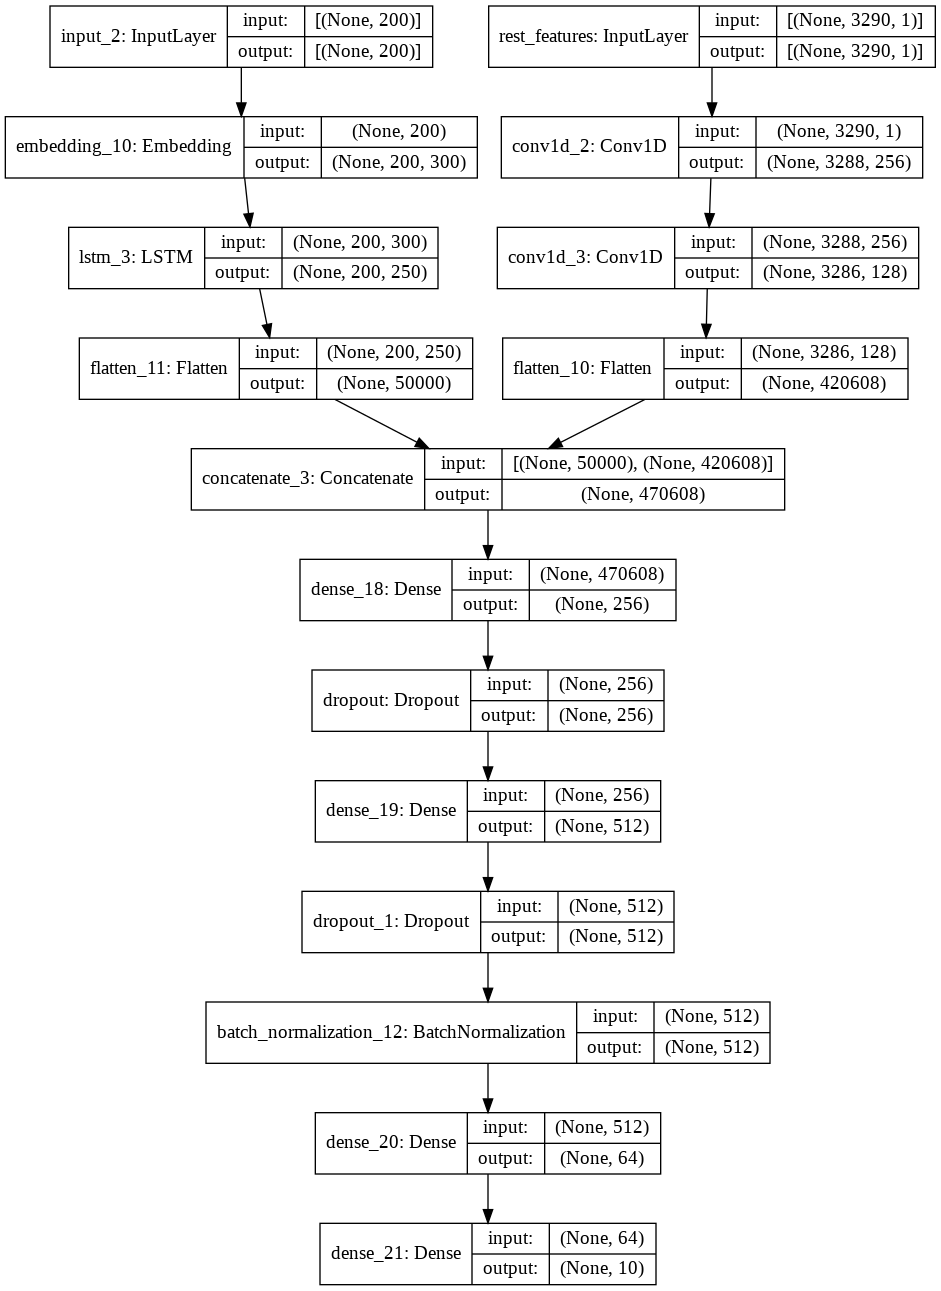

In [79]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [93]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy',metrics='accuracy')

In [94]:
from tensorflow.keras.callbacks import *
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min')
earlystop = EarlyStopping(monitor = 'val_loss',  mode="min",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, verbose = 1)
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard]

In [95]:
score_2=model.fit(x=train_s,y=y_train,validation_data=(test_s, y_test),epochs=50,callbacks=callbacks)

Epoch 1/50
73/73 [==============================] - 26s 304ms/step - loss: 2.7806 - accuracy: 0.1536 - val_loss: 2.0670 - val_accuracy: 0.4534

Epoch 00001: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 2/50
73/73 [==============================] - 21s 282ms/step - loss: 2.0184 - accuracy: 0.3868 - val_loss: 1.5666 - val_accuracy: 0.5928

Epoch 00002: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 3/50
73/73 [==============================] - 20s 274ms/step - loss: 1.6112 - accuracy: 0.5361 - val_loss: 1.3681 - val_accuracy: 0.6108

Epoch 00003: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 4/50
73/73 [==============================] - 20s 281ms/step - loss: 1.3851 - accuracy: 0.6015 - val_loss: 1.2886 - val_accuracy: 0.6369

Epoch 00004: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 5/50
73/73 [==============================] - 20s 275ms/step - loss: 1.2451 - accuracy: 0.6485 - val_loss: 1.2724 - val_accuracy: 0.6239

Epoch 00005: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 6/50
73/73 [==============================] - 21s 282ms/step - loss: 1.0935 - accuracy: 0.7014 - val_loss: 1.2564 - val_accuracy: 0.6158

Epoch 00006: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 7/50
73/73 [==============================] - 20s 273ms/step - loss: 0.9459 - accuracy: 0.7534 - val_loss: 1.2579 - val_accuracy: 0.6219

Epoch 00007: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 8/50
73/73 [==============================] - 21s 283ms/step - loss: 0.8398 - accuracy: 0.7874 - val_loss: 1.2244 - val_accuracy: 0.6449

Epoch 00008: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 9/50
73/73 [==============================] - 20s 275ms/step - loss: 0.7586 - accuracy: 0.8231 - val_loss: 1.2385 - val_accuracy: 0.6389

Epoch 00009: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 10/50
73/73 [==============================] - 21s 283ms/step - loss: 0.6617 - accuracy: 0.8541 - val_loss: 1.2157 - val_accuracy: 0.6469

Epoch 00010: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 11/50
73/73 [==============================] - 21s 283ms/step - loss: 0.5984 - accuracy: 0.8812 - val_loss: 1.2225 - val_accuracy: 0.6499

Epoch 00011: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 12/50
73/73 [==============================] - 21s 282ms/step - loss: 0.5424 - accuracy: 0.8946 - val_loss: 1.2436 - val_accuracy: 0.6590

Epoch 00012: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 13/50
73/73 [==============================] - 21s 283ms/step - loss: 0.4937 - accuracy: 0.9088 - val_loss: 1.2274 - val_accuracy: 0.6580

Epoch 00013: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 14/50
73/73 [==============================] - 21s 283ms/step - loss: 0.5015 - accuracy: 0.9075 - val_loss: 1.2384 - val_accuracy: 0.6520

Epoch 00014: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00014: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
Epoch 15/50
73/73 [==============================] - 20s 274ms/step - loss: 0.4669 - accuracy: 0.9204 - val_loss: 1.2356 - val_accuracy: 0.6520

Epoch 00015: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 16/50
73/73 [==============================] - 20s 276ms/step - loss: 0.4697 - accuracy: 0.9234 - val_loss: 1.2383 - val_accuracy: 0.6570

Epoch 00016: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00016: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
Epoch 17/50
73/73 [==============================] - 20s 274ms/step - loss: 0.4513 - accuracy: 0.9277 - val_loss: 1.2383 - val_accuracy: 0.6580

Epoch 00017: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 18/50
73/73 [==============================] - 20s 275ms/step - loss: 0.4611 - accuracy: 0.9178 - val_loss: 1.2358 - val_accuracy: 0.6590

Epoch 00018: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
Epoch 19/50
73/73 [==============================] - 20s 275ms/step - loss: 0.4554 - accuracy: 0.9277 - val_loss: 1.2348 - val_accuracy: 0.6600

Epoch 00019: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 20/50
73/73 [==============================] - 20s 275ms/step - loss: 0.4517 - accuracy: 0.9307 - val_loss: 1.2353 - val_accuracy: 0.6580

Epoch 00020: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00020: ReduceLROnPlateau reducing learning rate to 3.199999980552093e-08.
Epoch 21/50
73/73 [==============================] - 21s 282ms/step - loss: 0.4630 - accuracy: 0.9208 - val_loss: 1.2355 - val_accuracy: 0.6580

Epoch 00021: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 22/50
73/73 [==============================] - 20s 275ms/step - loss: 0.4882 - accuracy: 0.9170 - val_loss: 1.2358 - val_accuracy: 0.6550

Epoch 00022: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00022: ReduceLROnPlateau reducing learning rate to 6.399999818995639e-09.
Epoch 23/50
73/73 [==============================] - 20s 274ms/step - loss: 0.4674 - accuracy: 0.9238 - val_loss: 1.2341 - val_accuracy: 0.6590

Epoch 00023: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 24/50
73/73 [==============================] - 20s 274ms/step - loss: 0.4696 - accuracy: 0.9221 - val_loss: 1.2334 - val_accuracy: 0.6610

Epoch 00024: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.279999928271991e-09.
Epoch 25/50
73/73 [==============================] - 21s 283ms/step - loss: 0.4760 - accuracy: 0.9217 - val_loss: 1.2320 - val_accuracy: 0.6590

Epoch 00025: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 26/50
73/73 [==============================] - 20s 274ms/step - loss: 0.4503 - accuracy: 0.9286 - val_loss: 1.2329 - val_accuracy: 0.6620

Epoch 00026: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00026: ReduceLROnPlateau reducing learning rate to 2.55999976772614e-10.
Epoch 27/50
73/73 [==============================] - 20s 275ms/step - loss: 0.4536 - accuracy: 0.9225 - val_loss: 1.2323 - val_accuracy: 0.6630

Epoch 00027: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 28/50
73/73 [==============================] - 21s 283ms/step - loss: 0.4749 - accuracy: 0.9208 - val_loss: 1.2320 - val_accuracy: 0.6620

Epoch 00028: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00028: ReduceLROnPlateau reducing learning rate to 5.119999424429978e-11.
Epoch 29/50
73/73 [==============================] - 20s 274ms/step - loss: 0.4574 - accuracy: 0.9316 - val_loss: 1.2357 - val_accuracy: 0.6560

Epoch 00029: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 30/50
73/73 [==============================] - 20s 275ms/step - loss: 0.4595 - accuracy: 0.9238 - val_loss: 1.2345 - val_accuracy: 0.6590

Epoch 00030: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0239999126415712e-11.
Epoch 31/50
73/73 [==============================] - 21s 283ms/step - loss: 0.4602 - accuracy: 0.9217 - val_loss: 1.2352 - val_accuracy: 0.6610

Epoch 00031: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 32/50
73/73 [==============================] - 20s 274ms/step - loss: 0.4724 - accuracy: 0.9187 - val_loss: 1.2354 - val_accuracy: 0.6620

Epoch 00032: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00032: ReduceLROnPlateau reducing learning rate to 2.0479997905886727e-12.
Epoch 33/50
73/73 [==============================] - 20s 275ms/step - loss: 0.4488 - accuracy: 0.9329 - val_loss: 1.2348 - val_accuracy: 0.6610

Epoch 00033: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 34/50
73/73 [==============================] - 20s 274ms/step - loss: 0.4668 - accuracy: 0.9182 - val_loss: 1.2359 - val_accuracy: 0.6590

Epoch 00034: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00034: ReduceLROnPlateau reducing learning rate to 4.0959995811773456e-13.
Epoch 35/50
73/73 [==============================] - 21s 283ms/step - loss: 0.4654 - accuracy: 0.9144 - val_loss: 1.2364 - val_accuracy: 0.6580

Epoch 00035: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 36/50
73/73 [==============================] - 21s 284ms/step - loss: 0.4748 - accuracy: 0.9225 - val_loss: 1.2358 - val_accuracy: 0.6590

Epoch 00036: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00036: ReduceLROnPlateau reducing learning rate to 8.191999053934474e-14.
Epoch 37/50
73/73 [==============================] - 20s 275ms/step - loss: 0.4453 - accuracy: 0.9329 - val_loss: 1.2354 - val_accuracy: 0.6590

Epoch 00037: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 38/50
73/73 [==============================] - 21s 282ms/step - loss: 0.4714 - accuracy: 0.9178 - val_loss: 1.2357 - val_accuracy: 0.6590

Epoch 00038: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00038: ReduceLROnPlateau reducing learning rate to 1.638399837891949e-14.
Epoch 39/50
73/73 [==============================] - 20s 275ms/step - loss: 0.4631 - accuracy: 0.9230 - val_loss: 1.2358 - val_accuracy: 0.6580

Epoch 00039: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 40/50
73/73 [==============================] - 21s 283ms/step - loss: 0.4660 - accuracy: 0.9230 - val_loss: 1.2346 - val_accuracy: 0.6580

Epoch 00040: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00040: ReduceLROnPlateau reducing learning rate to 3.27679981130917e-15.
Epoch 41/50
73/73 [==============================] - 20s 275ms/step - loss: 0.4609 - accuracy: 0.9256 - val_loss: 1.2344 - val_accuracy: 0.6590

Epoch 00041: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 42/50
73/73 [==============================] - 20s 275ms/step - loss: 0.4619 - accuracy: 0.9234 - val_loss: 1.2339 - val_accuracy: 0.6600

Epoch 00042: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00042: ReduceLROnPlateau reducing learning rate to 6.553599792024929e-16.
Epoch 43/50
73/73 [==============================] - 20s 274ms/step - loss: 0.4777 - accuracy: 0.9243 - val_loss: 1.2342 - val_accuracy: 0.6560

Epoch 00043: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 44/50
73/73 [==============================] - 20s 275ms/step - loss: 0.4729 - accuracy: 0.9161 - val_loss: 1.2349 - val_accuracy: 0.6560

Epoch 00044: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00044: ReduceLROnPlateau reducing learning rate to 1.3107199584049857e-16.
Epoch 45/50
73/73 [==============================] - 20s 275ms/step - loss: 0.4512 - accuracy: 0.9269 - val_loss: 1.2362 - val_accuracy: 0.6560

Epoch 00045: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 46/50
73/73 [==============================] - 20s 275ms/step - loss: 0.4629 - accuracy: 0.9191 - val_loss: 1.2350 - val_accuracy: 0.6560

Epoch 00046: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00046: ReduceLROnPlateau reducing learning rate to 2.6214399168099714e-17.
Epoch 47/50
73/73 [==============================] - 20s 276ms/step - loss: 0.4674 - accuracy: 0.9269 - val_loss: 1.2359 - val_accuracy: 0.6560

Epoch 00047: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 48/50
73/73 [==============================] - 20s 275ms/step - loss: 0.4647 - accuracy: 0.9208 - val_loss: 1.2354 - val_accuracy: 0.6560

Epoch 00048: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00048: ReduceLROnPlateau reducing learning rate to 5.2428798336199434e-18.
Epoch 49/50
73/73 [==============================] - 20s 276ms/step - loss: 0.4808 - accuracy: 0.9118 - val_loss: 1.2341 - val_accuracy: 0.6570

Epoch 00049: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 50/50
73/73 [==============================] - 20s 276ms/step - loss: 0.4630 - accuracy: 0.9217 - val_loss: 1.2343 - val_accuracy: 0.6570

Epoch 00050: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00050: ReduceLROnPlateau reducing learning rate to 1.0485759998112131e-18.


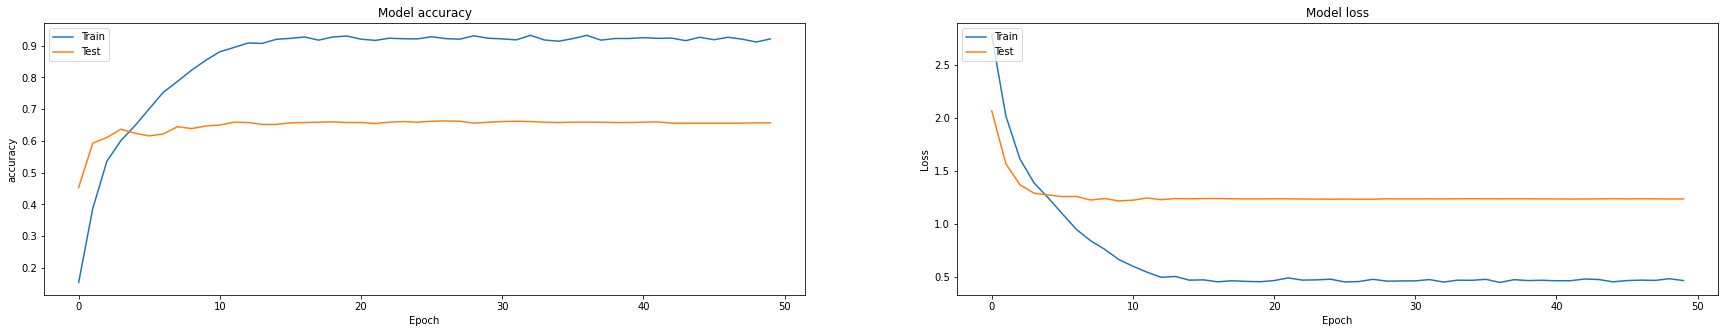

In [97]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(score_2.history['accuracy'])
plt.plot(score_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(score_2.history['loss'])
plt.plot(score_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()